In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from copy import deepcopy


In [2]:
def read_data(test):
    path = "job"+str(test)+".assign"
    f = open(path, "r")
    txt = f.readlines()
    mtrx = []
    matrix = []
    for i,line in enumerate(txt):
        mtrx.append(line.split(' '))
        matrix.append([])
        for j,num in enumerate(mtrx[i]):
            if num != '':
                matrix[i].append(num)
    if test == 1:
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                matrix[i][j] = int(matrix[i][j])
    
    elif test == 2 or test == 3:
        for i in range(len(matrix)):
            matrix[i].pop(-1)
            for j in range(len(matrix[i])):
                matrix[i][j] = int(matrix[i][j])
    return matrix

In [3]:
class Ant:
    def __init__(self):
        self.path = []
        self.cost = 0
    
    def reset(self):
        self.path = []
        self.cost = 0
    

In [34]:
class Colony:
    def __init__(self, ant_num, matrix , base_formun, T_SA, SA_rate, beta, p_local, alpha, q_0):
        self.n = len(matrix)
        self.matrix = matrix
        self.ant_num = ant_num
        self.T = T_SA
        self.beta = beta
        self.alpha = alpha
        self.p = p_local
        self.base_formun = base_formun
        self.q_0 = q_0
        self.SA_rate = SA_rate

        self.ants = []
        for i in range(ant_num):
            ant = Ant()
            self.ants.append(ant)
        
            
        
        self.formun = [[0 for j in range(self.n)] for i in range(self.n)]
        for i in range(self.n):
            for j in range(self.n):
                self.formun[i][j] = self.base_formun / self.matrix[i][j]
        self.init_formun = self.formun.copy()
    
    
    def training(self,itteration=100,print_itter = False):
        his = []
        his_path = []
        for itter in range(itteration):
#             print(itter,end=': ')
            self.spread_ants()
            self.formun = self.init_formun
            self.T *= self.SA_rate
            
            for step in range(self.n - 1):
                for ant in self.ants:
                    self.move(ant)
#                     self.local_update_formun(ant)
            path, cost = self.find_best_path()
            if print_itter == True:
                print(cost)
            temp_path = deepcopy(path)
            temp_path = self.mutation(temp_path)
            
            delta = self.fitness(temp_path) - self.fitness(path)
            if(delta < 0 or random.uniform(0, 1) < math.exp(-delta / self.T)):
                path = temp_path
                cost = self.fitness(temp_path)
            self.global_update_formun(path,cost)
            
            
            his.append(cost)
            his_path.append(path)
            for ant in self.ants:
                ant.reset()
        return his,his_path
    
    
    def spread_ants(self):
        nodes = list(range(self.n))
        random.shuffle(nodes)
        for i,ant in enumerate(self.ants):
            if i < self.n:
                ant.path.append(nodes[i])
                ant.cost += self.matrix[0][nodes[i]]
            else:
                state = random.choice(list(range(self.n)))
                ant.path.append(state)
                ant.cost += self.matrix[0][state]



    def local_update_formun(self,ant):
        i = len(ant.path)-1
        j = ant.path[-1]
        
#         delta = 0
#         for z in range(self.n):
#             if z != j and z != i:
#                 temp = 0.7 * self.formun[j][z]
#                 if temp > delta:
#                     delta = temp
        
        delta = self.init_formun[i][j]

        self.formun[i][j] = ((1-self.p)* self.formun[i][j]) + (self.p*(1/(delta)))

    def find_best_path(self):
        optima_path = []
        best_cost = float('inf')
        
        for ant in self.ants:
            if ant.cost < best_cost:
                best_cost = ant.cost
                optima_path = ant.path

#         print(best_cost)
#         print(optima_path)
        return optima_path, best_cost

    def global_update_formun(self,path,cost):
        for i in range(self.n):
            self.formun[i][path[i]] += (self.alpha*(cost**-1))
                
        for i in range(self.n):
            for j in range(self.n):
                self.formun[i][j] = (1-self.alpha)*self.formun[i][j] 
    
    def select_next_node(self,ant):
        q = random.random()
        if q < self.q_0:
            maxx = 0
            selected = None
            for node in range(self.n):
                if not node in ant.path:
                    rule = self.formun[len(ant.path)][node] * ((1/self.matrix[len(ant.path)][node])**self.beta)
                    if rule > maxx:
                        maxx = rule
                        selected = node
            return selected

        else:
            prob = [0 for i in range(self.n)]
            summ = 0
            for node in range(self.n):
                if not node in ant.path:
                    summ += self.formun[len(ant.path)][node] * ((1/self.matrix[len(ant.path)][node])**self.beta)

            for node in range(self.n):
                if not node in ant.path:
                    prob[node] = (self.formun[len(ant.path)][node] * ((1/self.matrix[len(ant.path)][node])**self.beta))/summ
                    a = random.choices(list(range(self.n)), prob, k=1)
            return a[0]

    def move(self,ant):
        next_node = self.select_next_node(ant)
        ant.cost += self.matrix[len(ant.path)][next_node]
        ant.path.append(next_node)

                
    def mutation(self,path):
        point_1, point_2 = random.sample(range(self.n), 2)
        path[point_1] , path[point_2] = path[point_2] , path[point_1]
        return path
    
    def fitness(self,path):
        cost = 0
        for i in range(self.n):
            cost += self.matrix[i][path[i]]
        return cost 

In [39]:
test = read_data(2)
colony = Colony(ant_num = 20, 
                matrix = test ,
                base_formun = 10, 
                T_SA = 1, 
                SA_rate = 0.9, 
                beta = 10, 
                p_local = 0.4, 
                alpha = 0.2,
                q_0 = 0.7
               )
hist,his_path = colony.training(50)

print(min(hist))
print(his_path[hist.index(min(hist))])

339
[67, 11, 10, 74, 28, 44, 95, 56, 22, 43, 21, 30, 87, 97, 12, 84, 0, 60, 29, 26, 19, 72, 31, 24, 5, 9, 64, 88, 92, 46, 58, 77, 50, 98, 75, 35, 33, 55, 13, 71, 79, 18, 86, 48, 91, 3, 27, 99, 90, 25, 82, 45, 36, 20, 54, 89, 41, 37, 38, 52, 53, 14, 66, 59, 47, 65, 39, 62, 78, 7, 63, 94, 70, 23, 76, 4, 69, 42, 40, 68, 51, 80, 16, 17, 83, 8, 57, 49, 32, 73, 81, 6, 61, 1, 85, 2, 34, 96, 15, 93]


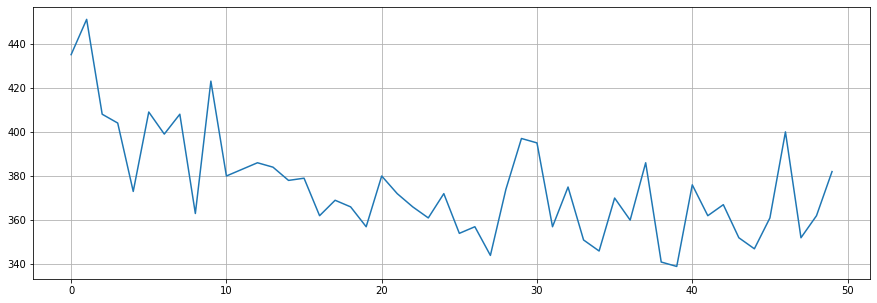

339


In [40]:
fig = plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(range(50), hist)
plt.show()
print(min(hist))

In [41]:
test = read_data(1)
colony = Colony(ant_num = 5, 
                matrix = test ,
                base_formun = 10, 
                T_SA = 1, 
                SA_rate = 0.9, 
                beta = 10, 
                p_local = 0.4, 
                alpha = 0.2,
                q_0 = 0.7)
hist,his_path = colony.training(20)
print(min(hist))
print(his_path[hist.index(min(hist))])

26
[3, 1, 2, 0]


In [45]:
test = read_data(3)
colony = Colony(ant_num = 20, 
                matrix = test ,
                base_formun = 10, 
                T_SA = 10, 
                SA_rate = 0.9, 
                beta = 10, 
                p_local = 0.4, 
                alpha = 0.2,
                q_0 = 0.7)
hist,his_path = colony.training(50)
print(min(hist))
print(his_path[hist.index(min(hist))])

711
[10, 27, 93, 176, 14, 104, 129, 15, 21, 40, 110, 68, 158, 195, 115, 66, 83, 11, 169, 42, 77, 45, 140, 106, 41, 149, 154, 3, 94, 87, 147, 16, 175, 23, 179, 161, 30, 142, 146, 170, 159, 32, 183, 56, 34, 58, 18, 160, 92, 148, 72, 132, 112, 90, 33, 39, 122, 128, 166, 20, 187, 85, 116, 52, 62, 165, 131, 55, 114, 44, 103, 73, 64, 48, 194, 82, 86, 31, 75, 4, 101, 196, 108, 168, 50, 190, 1, 28, 65, 107, 12, 198, 199, 181, 38, 46, 76, 178, 80, 189, 102, 25, 51, 35, 136, 177, 182, 63, 138, 78, 29, 113, 84, 24, 120, 88, 172, 19, 156, 81, 47, 191, 37, 192, 126, 134, 135, 5, 193, 174, 71, 143, 67, 2, 117, 57, 173, 36, 144, 145, 17, 7, 186, 0, 137, 184, 98, 125, 22, 8, 157, 89, 163, 69, 171, 162, 141, 139, 118, 49, 127, 111, 97, 121, 43, 119, 124, 79, 150, 99, 155, 123, 53, 197, 96, 70, 6, 105, 91, 9, 151, 61, 109, 167, 185, 130, 152, 100, 164, 188, 74, 54, 13, 59, 95, 26, 180, 153, 133, 60]


In [48]:
test = read_data(3)
colony = Colony(ant_num = 20, 
                matrix = test ,
                base_formun = 10, 
                T_SA = 10, 
                SA_rate = 0.9, 
                beta = 10, 
                p_local = 0.4, 
                alpha = 0.2,
                q_0 = 0.7)
hist,his_path = colony.training(50)
print(min(hist))
print(his_path[hist.index(min(hist))])

744
[59, 27, 93, 176, 14, 104, 122, 15, 21, 40, 110, 128, 158, 195, 115, 174, 83, 11, 173, 120, 77, 45, 140, 106, 48, 69, 125, 3, 94, 87, 147, 16, 175, 23, 179, 72, 30, 142, 146, 170, 159, 32, 183, 56, 34, 58, 18, 160, 92, 68, 178, 132, 112, 103, 33, 39, 13, 181, 51, 20, 187, 85, 116, 52, 62, 165, 131, 55, 114, 44, 188, 31, 64, 29, 194, 82, 86, 81, 88, 4, 101, 196, 108, 168, 78, 190, 73, 28, 65, 107, 12, 198, 154, 6, 38, 53, 166, 99, 80, 189, 102, 25, 61, 35, 136, 148, 182, 63, 138, 134, 139, 113, 84, 24, 150, 67, 172, 133, 156, 41, 47, 191, 37, 192, 126, 10, 137, 5, 193, 143, 71, 109, 149, 2, 117, 57, 79, 1, 144, 145, 17, 7, 186, 0, 135, 184, 98, 169, 22, 8, 157, 89, 19, 111, 36, 162, 46, 163, 118, 76, 127, 129, 90, 121, 43, 177, 171, 66, 54, 49, 155, 123, 42, 197, 96, 70, 50, 105, 91, 9, 151, 60, 124, 167, 185, 161, 152, 100, 164, 119, 74, 75, 141, 199, 95, 26, 180, 153, 97, 130]


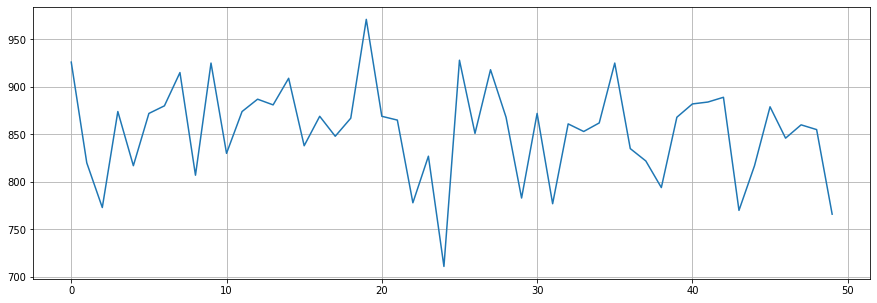

711


In [47]:
fig = plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(range(50), hist)
plt.show()
print(min(hist))